In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(seed=100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

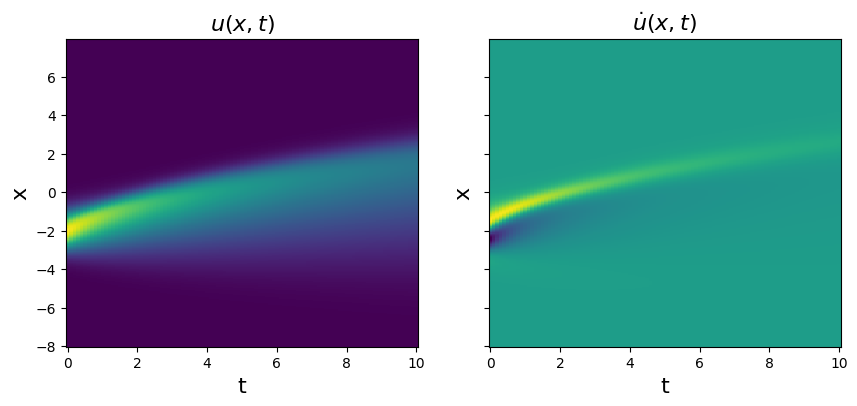

In [3]:
# Load data from .mat file
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
u_dot = u_dot.reshape(len(x), len(t), 1)

In [8]:
model.predict(u)[:,:,0]

AxesArray([[ 1.42421616e-15, -1.31735207e-08,  1.47423778e-07, ...,
             8.49100336e-05,  8.72866129e-05,  8.97919834e-05],
           [ 7.47713485e-15, -4.39989363e-09,  4.91050069e-08, ...,
             9.63022411e-05,  9.88933517e-05,  1.01526050e-04],
           [ 1.35300535e-14,  4.37373343e-09, -4.92137642e-08, ...,
             1.07688286e-04,  1.10493526e-04,  1.13253138e-04],
           ...,
           [ 2.78167219e-15, -4.45302208e-09,  4.85514027e-08, ...,
             6.02405144e-05,  6.21802171e-05,  6.41686819e-05],
           [-5.34081060e-16,  4.45014837e-09, -4.87072745e-08, ...,
             6.79308866e-05,  7.00667681e-05,  7.21774499e-05],
           [-3.84983431e-15,  1.33533188e-08, -1.45965952e-07, ...,
             7.56184484e-05,  7.79502995e-05,  8.01829831e-05]])

In [4]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=2,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.5, max_iter=10000, tol=1e-15,
    thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual",
                   normalize_columns=True,
                   kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SR3 model, L0 norm: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SR3 model, L1 norm: 
(x0)' = -0.001 x0_1 + 0.100 x0_11 + -1.000 x0x0_1
SSR model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SSR (metric = model residual) model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
FROLs model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
